In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# --------------------------Useful functions--------------------------

In [2]:
# unique item finder

def uniquefinder(mylist):
    '''
    Function finds unique values within a list, also stats on occurance rates
    
    inputs: an array or list 
            (integers or strings)
    2 outputs: dictionary of occurances, list of unique values 
    '''
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('There are {} unique tics out of the original {}.'.format(uniques,len(mylist)),\
        '\nUse the first output dictionary', \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

In [3]:
#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    '''
    inputs: a,b
            both lists or arrays
    outputs: not in b, not in a
            two lists
    '''
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a

In [4]:
#remix---only does 1st sector from every tic
def plot_1sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    count = 0
    for sec in sectors:
        lcsectorpaths = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
        if count % 2 == 0:
            try:
                lcfile = lk.open(lcsectorpaths)
                lcfile.scatter()
                plt.title('TIC:{},sector:{}'.format(tic,sec))
                count +=1
            except FileNotFoundError:
                #print('nothing for tic:{} sector:{}'.format(tic,sec))
                count +=2
        else:
            continue

In [5]:
def find_range(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)


def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return m.floor(n * multiplier) / multiplier


def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return m.ceil(n * multiplier) / multiplier

In [6]:
# labels meanings RF-1
def label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    2==Complex = "clear periodicity but complicated by multiple spots or low signal to noise";
    3== EB = "eclipsing binaries"; 
    4==Binaries = "likely eclipsing binaries too"; 
    5==Flat = "no rotational modulation"
    '''
    mydictionary = {1:'Periodic',2:'Complex',3:'Eclipsing Binary',4:'Binary',5:'Flat'}
    return(mydictionary[label])

In [7]:
# newer label_meanings #only 3 categories RF-2
def newer_label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    2==Complex = "clear periodicity but complicated by multiple spots or low signal to noise";
    3== EB = "eclipsing binaries"; 
    4==Binaries = "likely eclipsing binaries too"; 
    5==Flat = "no rotational modulation"
    '''
    mydictionary = {1:'Astrophysical Signal',2:'Likely Eclipsing Binary',3:'Flat'}
    return(mydictionary[label])

In [8]:
#this is trash, not good 

# def find_bins(x, axis=0):
#     datalen = len(x)
#     datarange = (round_up(np.max(x,axis=axis))+1) - (round_down(np.min(x,axis=axis)-1))
#     if datarange < datalen:
#         numbins = datalen / datarange
#     else:
#         numbins = datarange/20 #think this is really binsize
#     return numbins

# ----------------------------Load data---------------------------------------

In [9]:
bigstats = ascii.read('data/bigstats_stitchedlcs.fits')
secstats = ascii.read('data/bigstats_by_sector.fits')
mqdata = pd.read_csv('data/mcquillan_sample.csv')
alltics = np.load('data/all_dled_tics.npy')
goodtics = np.load('data/good_cvz_tics.npy') #only cvz tics (10+sectors)
tictable = ascii.read('data/tic_table.fits')
# labels = pd.read_csv('data/Classification_TICS.csv', header=3) #skiprows=2


labels = pd.read_csv('data/Classification_TICS.csv', header=3) #skiprows=2



#create subset that matches training set characteristics
cvzstats = bigstats[bigstats['TOTsecs']>=10]

In [10]:
# stats for training set

idxs=[]
for i in labels['TIC'].to_numpy():
    idx = np.where(bigstats['ID']==i)[0]
    if len(idx) != 0:
        idxs.append(idx)
    else:
        pass
trainstats = bigstats[idxs] #this includes 4 rows that have nan values & 6 rows that were never in bigstats runs
np.min(trainstats['TOTsecs']),len(trainstats),len(labels) #be aware that 6 training examples werent in my bigstats table

(10, 267, 273)

In [104]:
## used to check if EB labels are really EBs


# for count,tic in enumerate(labels[labels['CLASS']==3]['TIC'][19::].to_numpy()):
#     print(count)
#     if count == 20:
#         break
#     else:
#         plot_1sector(tic)

# ---------------------------Format training data & labels----------------------------

In [11]:
#labels
# removing repeats in labels

#explores number of repeats
dictofseen, unique_labels = uniquefinder(labels['TIC'].to_numpy())
print('Number of repeats in labels was:',len(labels)-len(unique_labels))

#maintain variable name after removing repeats
labels.drop_duplicates(subset ="TIC", 
                     keep = 'first', inplace = True) 

print('final sample size is now:',len(labels),'which better match:',len(unique_labels))

There are 259 unique tics out of the original 273. 
Use the first output dictionary to see number of occurances for duplicates
Number of repeats in labels was: 14
final sample size is now: 259 which better match: 259


In [12]:
#labels
# ensure training data has equal representation from each class

sampling = np.histogram(labels['CLASS'],bins = np.arange(1,7,1)) #finds # of classes per 1-6 grouping
print('Number of samples:',sampling[0],'in class bins:',sampling[1])

#try grabbing some more ec's from the 10+sectors in agreement stats

Number of samples: [93 50 29 37 50] in class bins: [1 2 3 4 5 6]


In [13]:
# training set data from labels
# pull benchmark stats

#set up empty dataframe to append data to
data = pd.DataFrame(columns=['ID','rvar','ls1','ls2','ls3','lsamp1','lsamp2','lsamp3','acf1','acf2','acf3','acfamp1','acfamp2','acfamp3','Teff','Bmag','Vmag','Tmag'])
# these columns only had nans in tictable: 'gmag','umag','rmag','imag','zmag'
#pull data and append
for row in bigstats:
    tic = row['ID']
    if tic in labels['TIC'].to_numpy():
        data = data.append({'ID':int(row['ID']),'rvar':row['rvar'],'ls1':row['ls1'],'ls2':row['ls2'],'ls3':row['ls3'],
                            'lsamp1':row['lsamp1'],'lsamp2':row['lsamp2'],'lsamp3':row['lsamp3'],'acf1':row['acf1'],
                            'acf2':row['acf2'],'acf3':row['acf3'],'acfamp1':row['acfamp1'],'acfamp2':row['acfamp2'],
                            'acfamp3':row['acfamp3'],'Teff':row['Teff'],'Bmag':row['Bmag'],'Vmag':row['Vmag'],'Tmag':row['Tmag']}, ignore_index=True)
    else:
        pass
data_withnans = len(data)
print('data length:',len(data))        

data length: 253


In [14]:
print('length of data:',len(data), 'is less than length of lables',len(labels),'. Think b/c those "extras/additions" werent',
      'in the original run')

length of data: 253 is less than length of lables 259 . Think b/c those "extras/additions" werent in the original run


In [15]:
# training set data
# drop data rows if they include nans

data = data.dropna()#axis='columns') #ugh Bmag had some missing so cant drop columns, this drops row if ANY nan

nandrop = data_withnans - len(data)
############try just dropping rows if theres nans

print('data length:', len(data)) #make sure length matches label lenght
data 

data length: 249


ID      rvar        ls1        ls2        ls3    lsamp1  \
0    139371600.0  0.004312   4.405840   4.768137   4.123799  0.013442   
1    140579537.0  0.011740   5.511737  11.058362   6.093628  0.134257   
2    140579674.0  0.015263   2.247234   6.658397   6.978570  0.196899   
3    140580497.0  0.014146  10.264962   9.369888  10.688587  0.000516   
4    140580634.0  0.002660   3.583130   3.535968   3.762793  0.001572   
..           ...       ...        ...        ...        ...       ...   
248  176980970.0  0.036448   0.611375   0.610075   0.612666  0.553989   
249  176982916.0  0.007806   6.725787   6.533500   6.898500  0.118976   
250  177022213.0  0.013422   5.587966   5.308952   5.416565  0.191911   
251  177075293.0  0.009037  10.650269  11.058362   5.355680  0.100202   
252  177077336.0  0.004214  11.085061   6.059267  13.053336  0.115930   

       lsamp2    lsamp3      acf1       acf2       acf3   acfamp1   acfamp2  \
0    0.009037  0.007418  0.069445   4.530559   4.533337  0.240679  0.066762   
1    0.092020  0.050129  0.069445  11.245842  11.241676  0.720320  0.363383   
2    0.070410  0.069368  0.069445  13.543066   6.773617  0.805839  0.449300   
3    0.000505  0.000330  0.069445   0.116667   0.261111  0.095026  0.092341   
4    0.001207  0.000501  0.070833   0.170833   0.184722  0.108077  0.102594   
..        ...       ...       ...        ...        ...       ...       ...   
248  0.097359  0.065780  0.609723   0.069445   1.220834  0.541528  0.490411   
249  0.067545  0.045781  0.069445  13.225011  13.230566  0.604283  0.202240   
250  0.189438  0.167497  0.069445   5.413893   5.409727  0.805436  0.473005   
251  0.085914  0.050763  0.069445  10.695842  10.700009  0.481861  0.273918   
252  0.039871  0.013971  0.069445  11.455565  11.452787  0.379450  0.128835   

      acfamp3     Teff    Bmag    Vmag     Tmag  
0    0.066760  6200.91  11.424  10.857  10.3514  
1    0.363364  5578.00  12.821  12.045  11.0732  
2    0.402913  5119.00  13.869  11.797  11.1707  
3    0.083168  3471.00  16.273  14.599  12.3873  
4    0.101870  6334.19  10.500  10.035   9.5832  
..        ...      ...     ...     ...      ...  
248  0.484493  3257.00  17.450  16.053  13.2812  
249  0.202224  4238.00  13.275  11.793  10.6392  
250  0.473005  5569.58  12.632  11.770  11.1150  
251  0.273908  5548.39  12.626  11.823  11.2309  
252  0.128814  4907.96  11.766  10.753  10.0686  

[249 rows x 18 columns]

In [16]:
#labels - result for RF1 but need this cell to create labels for RF2 in next cell
# redoing labels to have correct order & same lenghts due to drop nans from dataset above

new_labels = []
for tic in data['ID'].to_numpy():
    idx = np.where(labels['TIC']==tic)
    category = labels['CLASS'].iloc[idx].values[0]
    new_labels.append(category)
print('label length:', len(new_labels)) #make sure length matches data length

label length: 249


In [17]:
#new labels for RF-2: change labels to only 3 classes
# 1 = astrophysical signal; 1 = binaries; 3 = flat
newer_labels = []
for i in new_labels:
    if i ==2: #make complex's into strong periodicity
        a=1
    elif i == 3 or i == 4: #make eclipsing binaries & those suspect rapid binaries one category
        a = 2
    elif i == 5:
        a = 3
    else:
        a = i
    newer_labels.append(a)
print(len(new_labels),len(newer_labels))

sampling = np.histogram(newer_labels,bins = np.arange(1,5,1)) #finds # of classes per 1-6 grouping
print('Number of samples:',sampling[0],'in class bins:',sampling[1])



249 249
Number of samples: [136  64  49] in class bins: [1 2 3 4]


In [18]:
RF1 = new_labels 
RF2 = newer_labels

In [19]:
# try scaling data


# -----------------------Explore correlations in data--------------------------
## RF-1_____________comment out b/c RF-2 was SO much better

In [20]:
# RF-1


# data['class'] = new_labels #rf-1 = labels
# data

In [21]:
#takes long to run, only do if have to 

# import seaborn as sns; sns.set(style="ticks", color_codes=True)

# sns.pairplot(data, height=4)#,plot_kws=dict(fontsize=50))#, hue= 'class',diag_kind="kde")#,diag_kws=dict(shade=True))

In [22]:
# sns.pairplot??
# for feature in data.columns:
#     print(data[feature].dtype)



In [23]:
# adjusting features (add/remove)

#remove class from dataset for rf training
# data = data.drop(columns=['class'])
# #try scaling teff, bmag, vmag, tmag

#inject random variable
np.random.seed(seed = 11)
data['random'] = np.random.random(size = len(data))

# #verify changes
# data

# ----------------------Build, train, test RF classifier-----------------------------
## RF-1 (5 classes)

In [24]:
# #set variable for feature data
# X = data 
# #set variable for correct labels with 5 classes
# y = new_labels
# #split data into test and training set
# X_train, test_X, y_train, test_y = train_test_split(X, y, random_state = 11)

In [25]:
# ####play with parms here to get better model




# #define random forest model
# rf_model = RandomForestClassifier(n_estimators = 100,
#                            n_jobs = -1,
#                            oob_score = True,
#                            bootstrap = True,
#                            random_state = 11,
#                            max_depth = 4) #criterion='entropy'
# # fit model to data
# rf_model.fit(X_train, y_train)

In [26]:
# # print accuracy scores
# print('Test Set Accuracy:',rf_model.score(test_X,test_y))  
# print('Training Set Accuracy:', rf_model.score(X_train,y_train))
# print('Out of the Box Accuracy:',rf_model.oob_score_)



In [27]:
####previous set with only 6 'flat curves'
# Test Set Accuracy: 0.7358490566037735
# Training Set Accuracy: 1.0
# Out of the Box Accuracy: 0.5705128205128205
####previous set with only dropping nan rows -keeps Bmag/Vmag
# Test Set Accuracy: 0.703125
# Training Set Accuracy: 1.0
# Out of the Box Accuracy: 0.708994708994709
###previous set with dropping nan columns - only keeps Vmag
# Test Set Accuracy: 0.5873015873015873
# Training Set Accuracy: 1.0
# Out of the Box Accuracy: 0.7150537634408602

In [28]:
# # Validate classifier

# # have fit model predict labels for previously unseen data
# predictions = rf_model.predict(test_X)
# # check the accuracy of fit model
# score = rf_model.score(test_X,test_y)
# accuracy = accuracy_score(test_y,predictions)
# print(accuracy)
# print(score)

## RF  - 2 (3 classes)

In [29]:
#set variable for feature data
X2 = data 
#set variable for correct labels
y2 = newer_labels
#split data into test and training set
X_train2, test_X2, y_train2, test_y2 = train_test_split(X2, y2, random_state = 11)

In [30]:
######play with parms here to get better model


#define random forest model
rf_model2 = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf_model2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=11, verbose=0,
                       warm_start=False)

In [31]:
# print accuracy scores
print('Test Set Accuracy:',rf_model2.score(test_X2,test_y2))  
print('Training Set Accuracy:', rf_model2.score(X_train2,y_train2))
print('Out of the Box Accuracy:',rf_model2.oob_score_)
# Test Set Accuracy: 0.8095238095238095
# Training Set Accuracy: 1.0
# Out of the Box Accuracy: 0.9139784946236559

Test Set Accuracy: 0.8571428571428571
Training Set Accuracy: 1.0
Out of the Box Accuracy: 0.9193548387096774


In [32]:
# Validate classifier

# have fit model predict labels for previously unseen data
predictions2 = rf_model2.predict(test_X2)
# check the accuracy of fit model
score2 = rf_model2.score(test_X2,test_y2)
accuracy2 = accuracy_score(test_y2,predictions2)
print(accuracy2)
print(score2)

0.8571428571428571
0.8571428571428571


# -----------------------feature importances----------------------------
# RF-1

In [33]:
# from sklearn.metrics import r2_score
# from rfpimp import permutation_importances

# def r2(rf, X_train, y_train):
#     return r2_score(y_train, rf.predict(X_train))

# perm_imp_rfpimp = permutation_importances(rf_model, X_train, y_train, r2)

In [34]:
# # import matplotlib.pyplot as plt
# # plt.barh(perm_imp_rfpimp.index,perm_imp_rfpimp[['Importance']])
# perm_imp_rfpimp.plot.barh()
# plt.xlabel('Feature_Importance');

In [35]:
# importances = rf_model.feature_importances_

# std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure(figsize=(15,10))
# plt.title("Feature importances",fontsize=25)
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# degrees = 70
# plt.xticks(range(X.shape[1]), X.columns[indices],fontsize=18,rotation=degrees)
# plt.xlim([-1, X.shape[1]])
# plt.yticks(fontsize=18)

# plt.show()

# feature importances RF-2

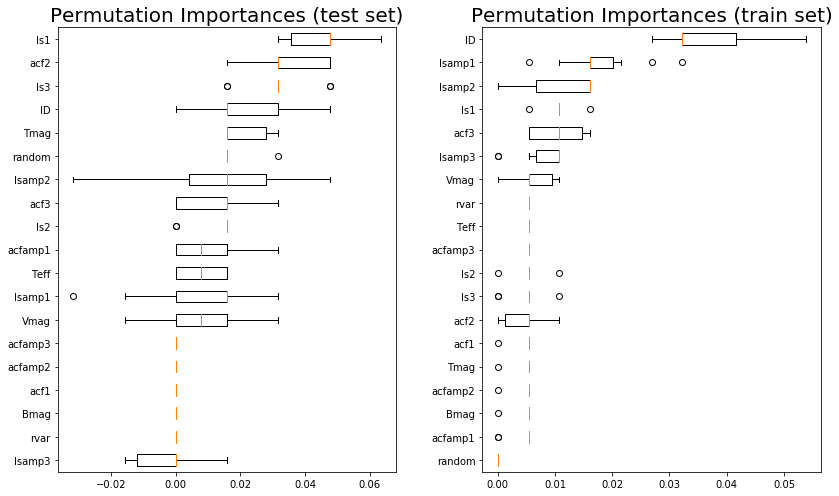

In [36]:
# permutation_importance (one for TRAIN dataset; one for TEST dataset)

result = permutation_importance(rf_model2, test_X2, test_y2, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X2.columns[sorted_idx])
ax1.set_title("Permutation Importances (test set)",fontsize=20)


result2 = permutation_importance(rf_model2, X_train2, y_train2, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx2 = result2.importances_mean.argsort()
ax2.boxplot(result2.importances[sorted_idx2].T,
           vert=False, labels=X_train2.columns[sorted_idx2])
ax2.set_title("Permutation Importances (train set)",fontsize=20)

fig.tight_layout()
plt.show()

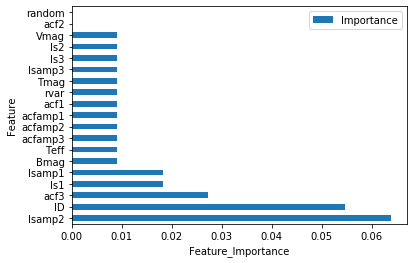

In [37]:
# permutation importance -- a googled way - not sklearn
def r22(rf, X_train2, y_train2):
    return r2_score(y_train2, rf.predict(X_train2))

perm_imp_rfpimp2 = permutation_importances(rf_model2, X_train2, y_train2, r22)
# import matplotlib.pyplot as plt
# plt.barh(perm_imp_rfpimp.index,perm_imp_rfpimp[['Importance']])
perm_imp_rfpimp2.plot.barh()
plt.xlabel('Feature_Importance');

Feature ranking:
1. feature 5 (0.139704)
2. feature 6 (0.132960)
3. feature 9 (0.119877)
4. feature 7 (0.105401)
5. feature 11 (0.100843)
6. feature 0 (0.097333)
7. feature 10 (0.087347)
8. feature 12 (0.038796)
9. feature 2 (0.030108)
10. feature 4 (0.028951)
11. feature 3 (0.019934)
12. feature 14 (0.016461)
13. feature 16 (0.015963)
14. feature 13 (0.015523)
15. feature 1 (0.014128)
16. feature 17 (0.012463)
17. feature 8 (0.010647)
18. feature 15 (0.008411)
19. feature 18 (0.005149)


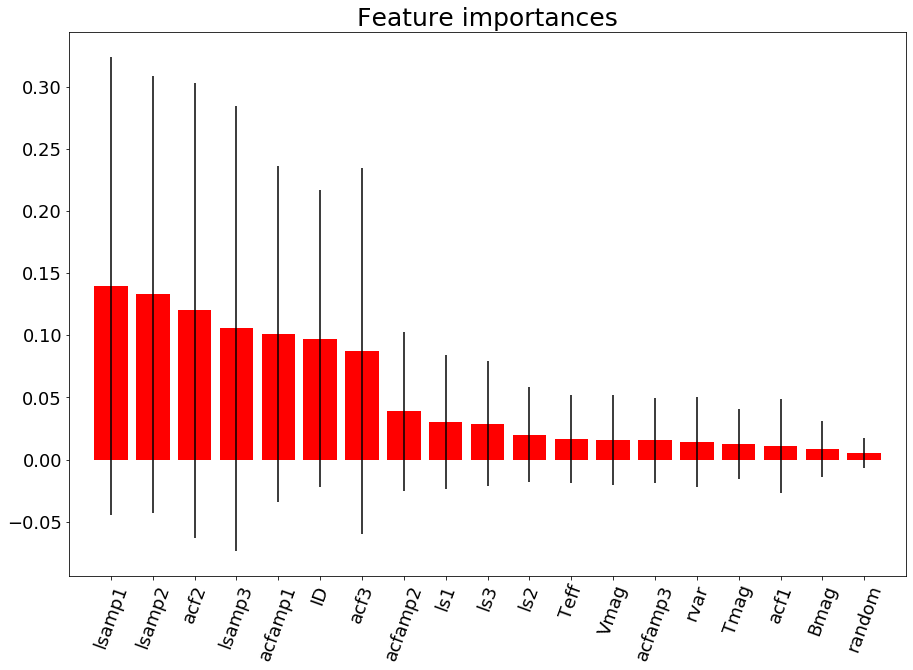

In [38]:
# sklearn - impurity based feature importance (uses training set)

importances2 = rf_model2.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in rf_model2.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances",fontsize=25)
plt.bar(range(X2.shape[1]), importances2[indices2],
       color="r", yerr=std2[indices2], align="center")
degrees = 70
plt.xticks(range(X2.shape[1]), X2.columns[indices2],fontsize=18,rotation=degrees)
plt.xlim([-1, X2.shape[1]])
plt.yticks(fontsize=18)
plt.show()

# ----------------Predict classes for unseen data---------------------
## format unseen data

In [39]:
## unseen full dataset (1+ sectors, several irrelevant features)
# remove training data from FULL sample (1+ sectors)

idx = [] 
# bench_tics = []
for count,row in enumerate(bigstats):
    tic = row['ID']
    if tic in labels['TIC'].to_numpy(): #remove training set
        pass
    else: #keep non-benchmark
        idx.append(count)
unseen = bigstats[idx] #use this as unseen dataset to run through classifier

print(len(bigstats)-len(unseen),len(X2)) #unseen does NOT include 4 rows that had nan values but OK b/c need to remove those anyway b/c nans cant go through RF model

253 249


In [40]:
## unseen dataset (10+ sectors, RF features only)
# create unseen for ONLY 10 or more sectors tics----this will match the training dataset


# gets stats for unseen with same min number of sectors as training data
unseen10up = unseen[unseen['TOTsecs']>=10]
unseen10up_data = pd.DataFrame(columns=['ID','rvar','ls1','ls2','ls3','lsamp1','lsamp2','lsamp3','acf1','acf2','acf3','acfamp1','acfamp2','acfamp3','Teff','Bmag','Vmag','Tmag'])
# these columns only had nans in tictable: 'gmag','umag','rmag','imag','zmag'
#pull data and append
for row in unseen10up:
    unseen10up_data = unseen10up_data.append({'ID':int(row['ID']),'rvar':row['rvar'],'ls1':row['ls1'],'ls2':row['ls2'],'ls3':row['ls3'],
                        'lsamp1':row['lsamp1'],'lsamp2':row['lsamp2'],'lsamp3':row['lsamp3'],'acf1':row['acf1'],
                        'acf2':row['acf2'],'acf3':row['acf3'],'acfamp1':row['acfamp1'],'acfamp2':row['acfamp2'],
                        'acfamp3':row['acfamp3'],'Teff':row['Teff'],'Bmag':row['Bmag'],'Vmag':row['Vmag'],'Tmag':row['Tmag']}, ignore_index=True)
print('unseen10up data WITH nans lenght:',len(unseen10up_data))


# remove nans from unseen data
unseen10up_data = unseen10up_data.dropna()

#inject random 
np.random.seed(seed = 11)
unseen10up_data['random'] = np.random.random(size = len(unseen10up_data))
print('unseen10up data withOUT nans lenght:',len(unseen10up_data))

unseen10up data WITH nans lenght: 5756
unseen10up data withOUT nans lenght: 5325


In [41]:
## unseen dataset (1+ sectors, RF features only)
# pull relevant columns for unseen data

#set up empty dataframe to append data to
unseen_data = pd.DataFrame(columns=['ID','rvar','ls1','ls2','ls3','lsamp1','lsamp2','lsamp3','acf1','acf2','acf3','acfamp1','acfamp2','acfamp3','Teff','Bmag','Vmag','Tmag'])
# these columns only had nans in tictable: 'gmag','umag','rmag','imag','zmag'
#pull data and append
for row in unseen:
    unseen_data = unseen_data.append({'ID':int(row['ID']),'rvar':row['rvar'],'ls1':row['ls1'],'ls2':row['ls2'],'ls3':row['ls3'],
                        'lsamp1':row['lsamp1'],'lsamp2':row['lsamp2'],'lsamp3':row['lsamp3'],'acf1':row['acf1'],
                        'acf2':row['acf2'],'acf3':row['acf3'],'acfamp1':row['acfamp1'],'acfamp2':row['acfamp2'],
                        'acfamp3':row['acfamp3'],'Teff':row['Teff'],'Bmag':row['Bmag'],'Vmag':row['Vmag'],'Tmag':row['Tmag']}, ignore_index=True)
print('unseen data WITH nans lenght:',len(unseen_data))    

# remove nans from unseen data
unseen_data = unseen_data.dropna()
len(unseen_data)

#inject random 
np.random.seed(seed = 11)
unseen_data['random'] = np.random.random(size = len(unseen_data))
print('unseen data withOUT nans lenght:',len(unseen_data))

unseen data WITH nans lenght: 23834
unseen data withOUT nans lenght: 22727


In [42]:
#sanity check of lenghts
dictofseen, uniques = uniquefinder(labels['TIC'].to_numpy())
print('missing due to duplicates:',len(labels)-len(uniques))
print('missing due to drop nans:', nandrop)
len(unseen),len(bigstats)-len(labels)# this is that 6 off again...think b/c of extras/additions

There are 259 unique tics out of the original 259. 
Use the first output dictionary to see number of occurances for duplicates
missing due to duplicates: 0
missing due to drop nans: 4


(23834, 23828)

## predictions from RF-1

In [43]:
# predictions = rf_model.predict(unseen_data)
# predictions10up = rf_model.predict(unseen10up_data)
# predictions , predictions10up


In [44]:
# x = predictions
# datalen = len(x)
# datarange = round_up(np.max(x,axis=0)) - round_down(np.min(x,axis=0))
# numbins = datalen / datarange
# print(numbins, datalen , datarange)

# find_bins(predictions)

In [45]:
# #all targets (1+ sectors)

# bins = np.arange(1,7,1)
# x = np.histogram(predictions,bins)[0]

            
# y = bins[:-1]
# plt.bar(y,x)
# plt.grid('on')
# plt.xlabel('CLASS')
# plt.ylabel('NUMBER')
# plt.xticks(range(1,x.shape[0]+1),[label_meanings(i) for i in y])
# plt.title('Predicted Classes for Unseen Data from RF-1');

In [46]:
# # cvz targets (10+ sectors)

# bins = np.arange(1,7,1)
# x = np.histogram(predictions10up,bins)[0]

            
# y = bins[:-1]
# plt.bar(y,x)
# plt.grid('on')
# plt.xlabel('CLASS')
# plt.ylabel('NUMBER')
# plt.xticks(range(1,x.shape[0]+1),[label_meanings(i) for i in y])
# plt.title('Predicted Classes for Unseen 10+ sectors Data from RF-1');

In [47]:
X2.columns

Index(['ID', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'acf1',
       'acf2', 'acf3', 'acfamp1', 'acfamp2', 'acfamp3', 'Teff', 'Bmag', 'Vmag',
       'Tmag', 'random'],
      dtype='object')

In [48]:
unseen_data.columns

Index(['ID', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'acf1',
       'acf2', 'acf3', 'acfamp1', 'acfamp2', 'acfamp3', 'Teff', 'Bmag', 'Vmag',
       'Tmag', 'random'],
      dtype='object')

## predictions from RF-2

In [49]:
# get predicitons 
predictions2 = rf_model2.predict(unseen_data) #(1+ sectors)
predictions10up2 = rf_model2.predict(unseen10up_data) #(10+ sectors)

predictions2,predictions10up2

(array([3, 2, 3, ..., 3, 1, 1]), array([3, 2, 3, ..., 1, 3, 1]))

UNSEEN DATA SIZE =  22727


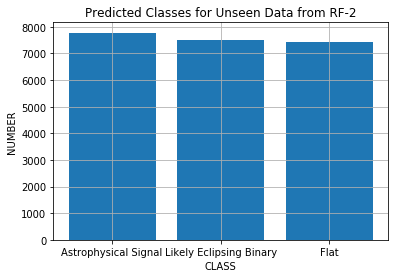

In [50]:
# all targets (1+ sectors)


bins2 = np.arange(1,5,1)
x2 = np.histogram(predictions2,bins2)[0]
predictsize_1 = len(unseen_data)
print('UNSEEN DATA SIZE = ', predictsize_1)
            
y2 = bins2[:-1]
plt.bar(y2,x2)
plt.grid('on')
plt.xlabel('CLASS')
plt.ylabel('NUMBER')
plt.xticks(range(1,x2.shape[0]+1),[newer_label_meanings(i) for i in y2])
plt.title('Predicted Classes for Unseen Data from RF-2');

UNSEEN DATA SIZE =  5325


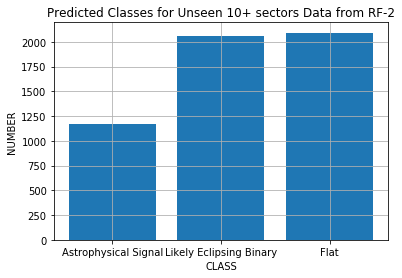

In [51]:
# cvz targets (10+ sectors)

bins = np.arange(1,5,1)
x = np.histogram(predictions10up2,bins)[0]
predictsize_10 = len(unseen10up_data)
print('UNSEEN DATA SIZE = ', predictsize_10)
            
y = bins[:-1]
plt.bar(y,x)
plt.grid('on')
plt.xlabel('CLASS')
plt.ylabel('NUMBER')
plt.xticks(range(1,x.shape[0]+1),[newer_label_meanings(i) for i in y])
plt.title('Predicted Classes for Unseen 10+ sectors Data from RF-2');

# --------------------check predicitons by eye----------------------

In [52]:
# # RF-1
# #match prediciton to tic
# predicted_table = Table([unseen_data['ID'],predictions],names=('ID','predict_class'))
# # predicted_table FROM RF-1
# flats1 = [int(i) for count,i in enumerate(predicted_table['ID']) if predicted_table['predict_class'][count] ==5]
# binaries1 = [int(i) for count,i in enumerate(predicted_table['ID']) if predicted_table['predict_class'][count] ==4]
# eclipsingb1 = [int(i) for count,i in enumerate(predicted_table['ID']) if predicted_table['predict_class'][count] ==3]
# complex1 = [int(i) for count,i in enumerate(predicted_table['ID']) if predicted_table['predict_class'][count] ==2]
# periodic1 = [int(i) for count,i in enumerate(predicted_table['ID']) if predicted_table['predict_class'][count] ==1]

# RF-2 (1+ sectors)
#match prediciton to tic
predicted_table2 = Table([unseen_data['ID'],predictions2],names=('ID','predict_class'))
# predicted_table FROM RF-2
flats2 = [int(i) for count,i in enumerate(predicted_table2['ID']) if predicted_table2['predict_class'][count] ==3]
binaries2 = [int(i) for count,i in enumerate(predicted_table2['ID']) if predicted_table2['predict_class'][count] ==2]
periodic2 = [int(i) for count,i in enumerate(predicted_table2['ID']) if predicted_table2['predict_class'][count] ==1]

# RF-2 (10+ sectors)
#match prediciton to tic
predicted_table10up2 = Table([unseen10up_data['ID'],predictions10up2],names=('ID','predict_class'))
# predicted_table FROM RF-2
flats10up2 = [int(i) for count,i in enumerate(predicted_table10up2['ID']) if predicted_table10up2['predict_class'][count] ==3]
binaries10up2 = [int(i) for count,i in enumerate(predicted_table10up2['ID']) if predicted_table10up2['predict_class'][count] ==2]
periodic10up2 = [int(i) for count,i in enumerate(predicted_table10up2['ID']) if predicted_table10up2['predict_class'][count] ==1]





25063396
25078674
25081173
25117273
25117406
29759800
29829259
29832530
29832730
30035088
30106967
30108310
30271577
30273869
30312254
30407429
30468581
30469371
30635299
30642087


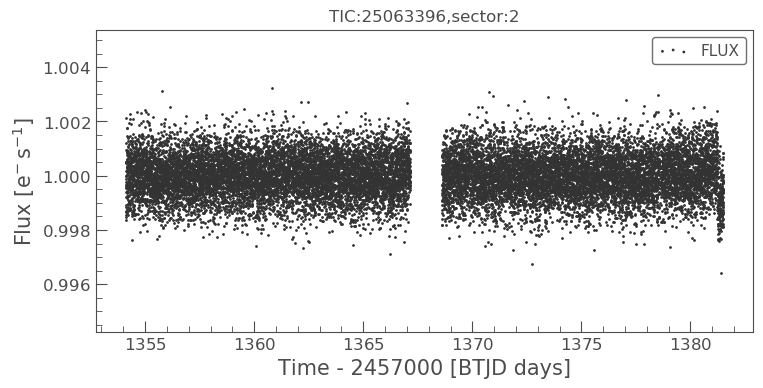

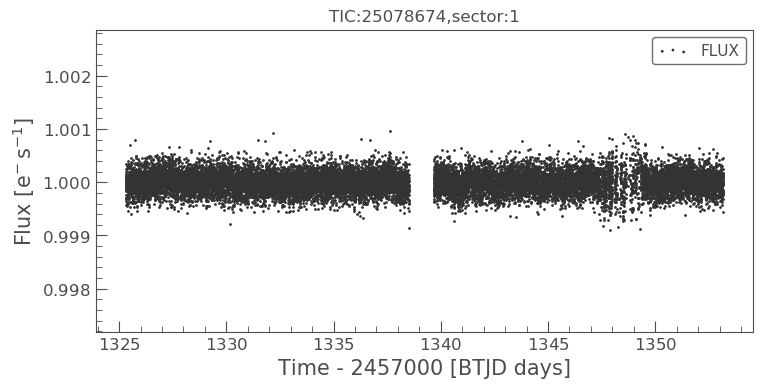

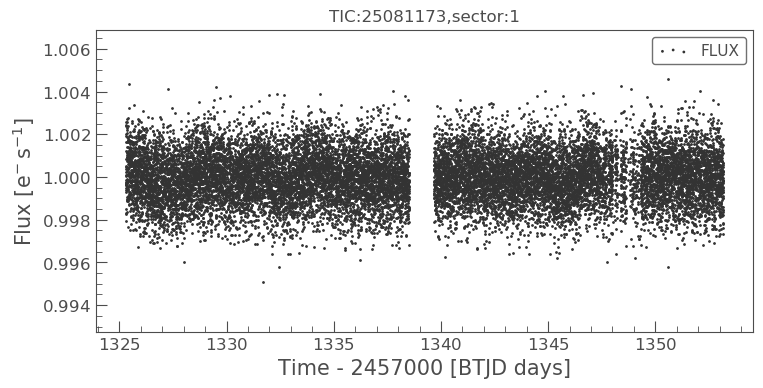

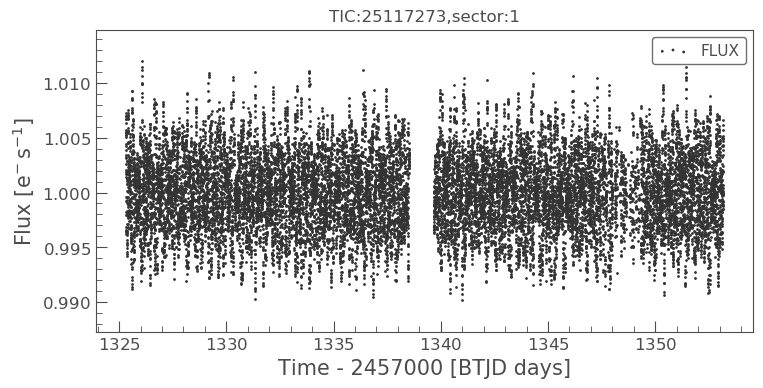

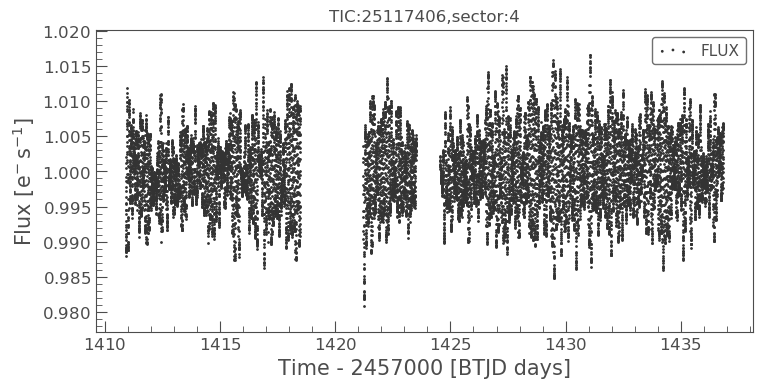

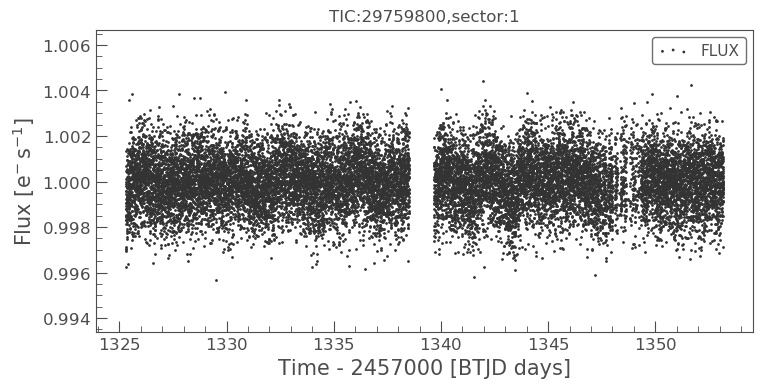

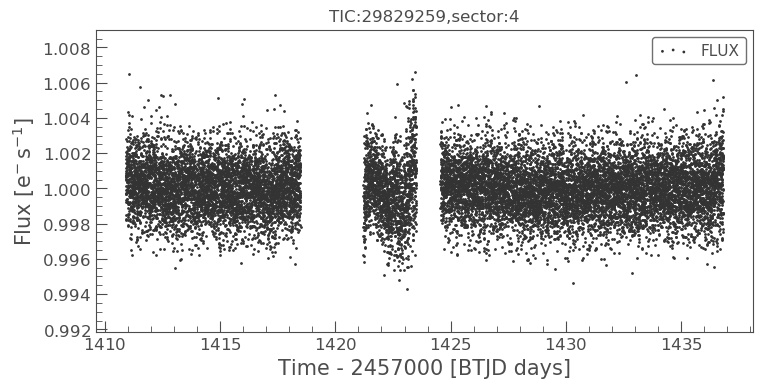

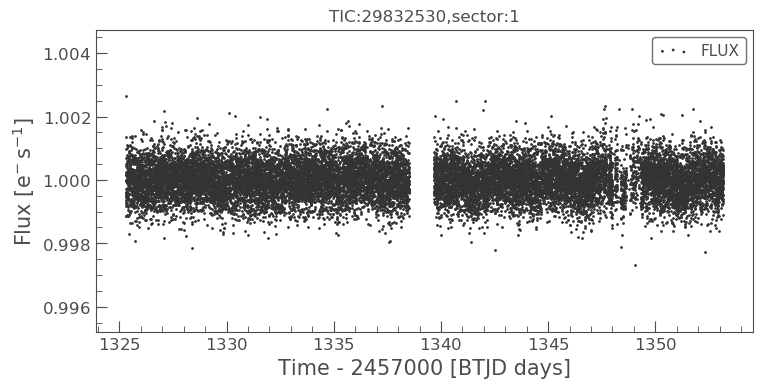

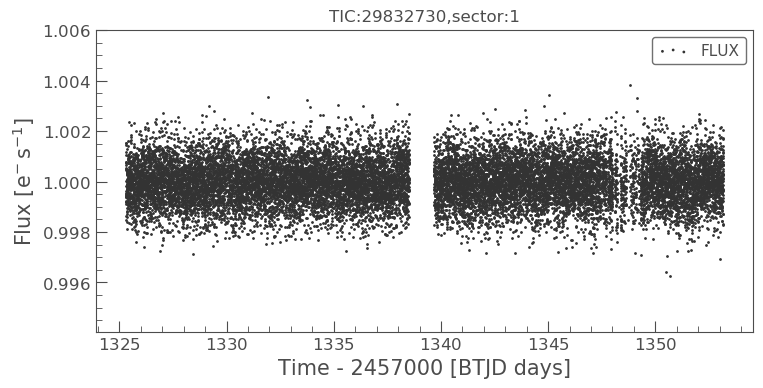

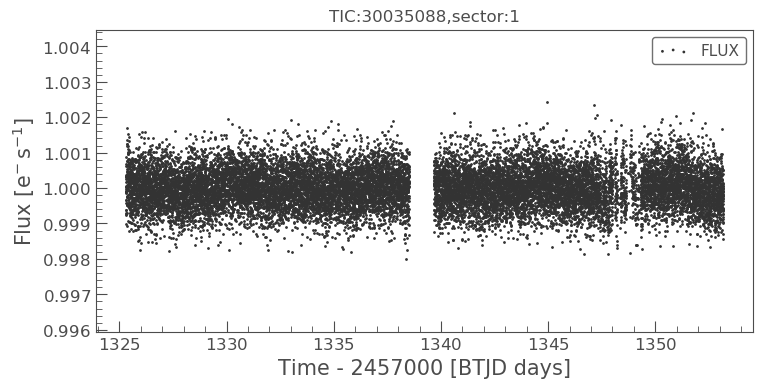

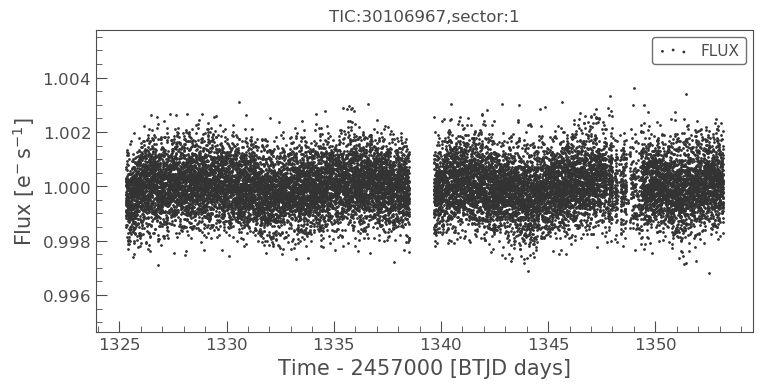

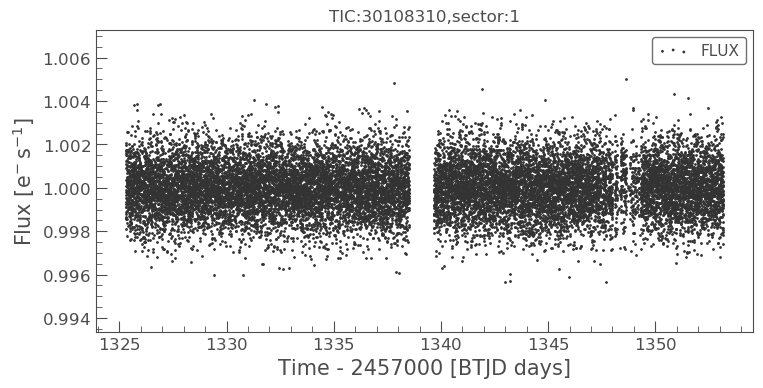

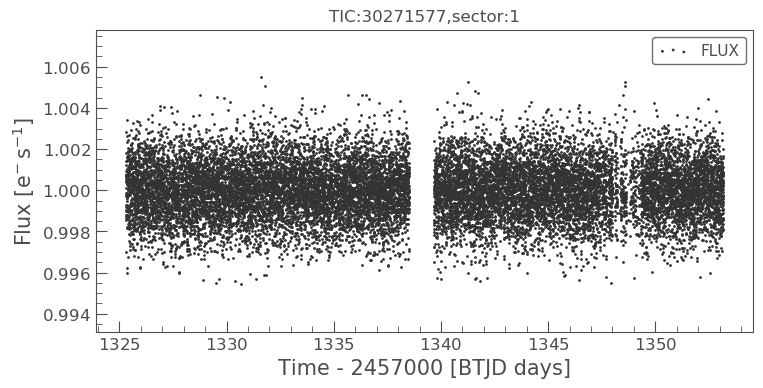

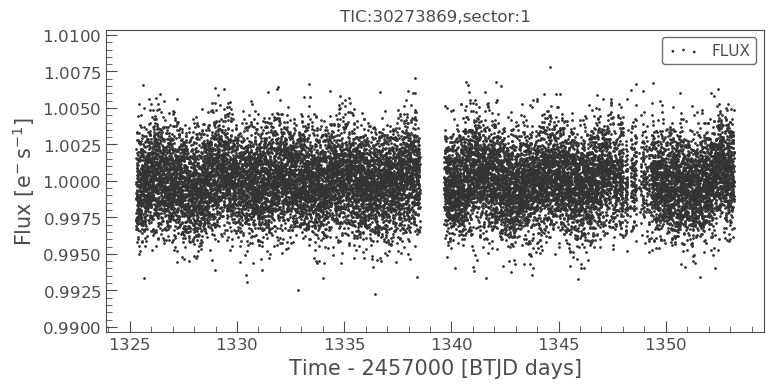

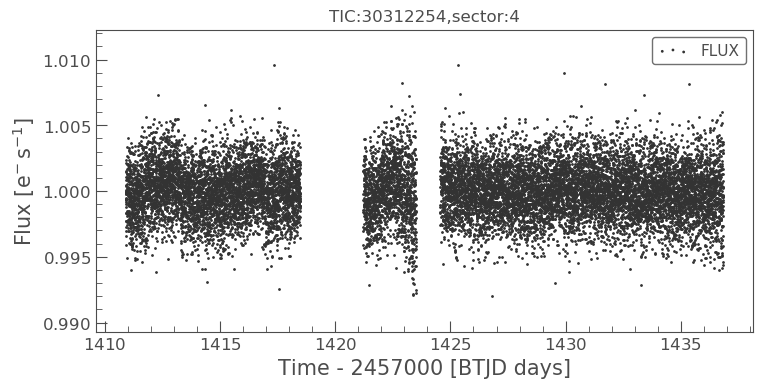

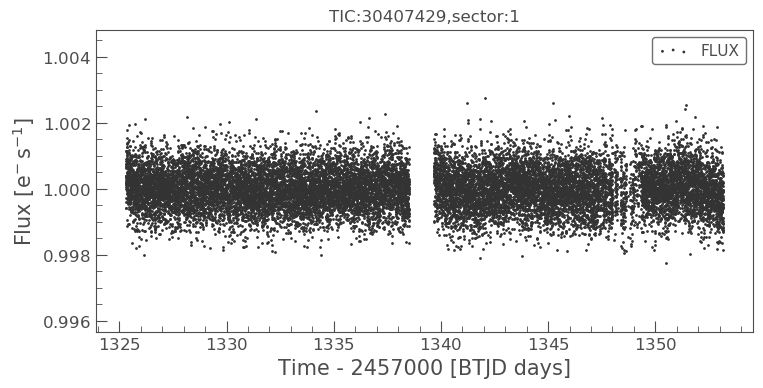

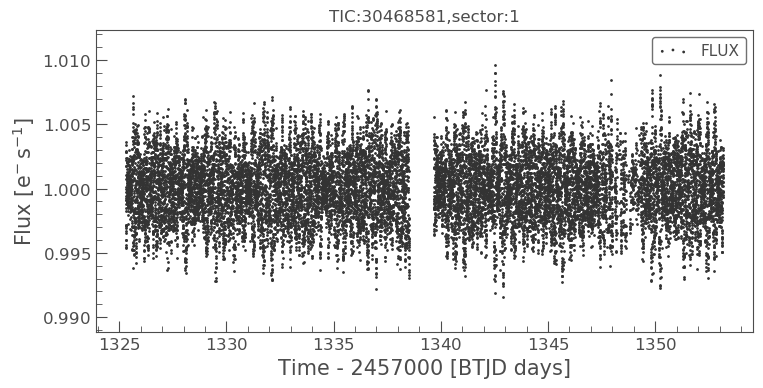

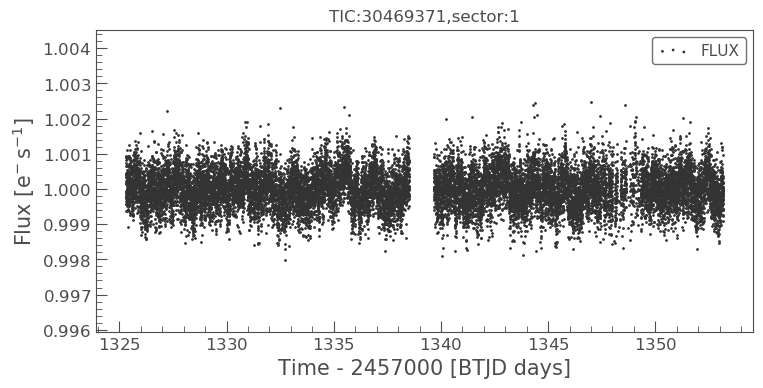

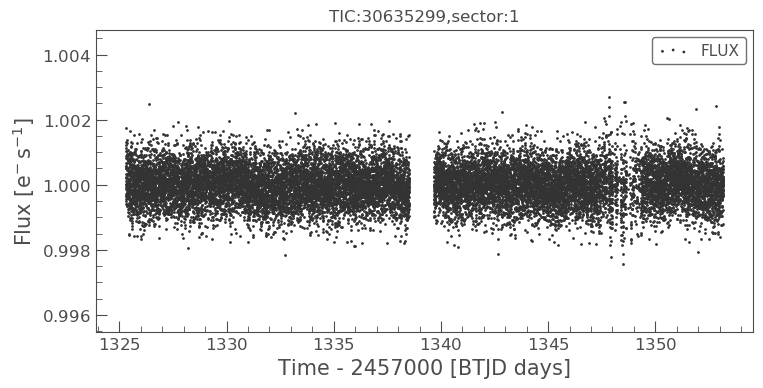

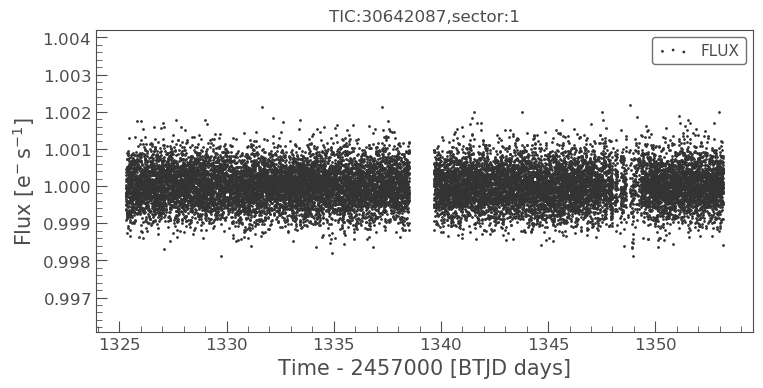

In [53]:

for j in flats10up2[0:20]: # each class for RF-2 IS roughly correct 4/20 wrong classifications
    print(j)
    plot_1sector(j)

# --------------------compare to sector stats---------------------------------
## format sector statistics

In [54]:
#get the number of tics with 3-10+ sectors consistent in rp
#sector stats

seen = {}
consistent10={}
consistent9={}
consistent8={}
consistent7={}
consistent6={}
consistent5={}
consistent4={}
consistent3={}
consists =[]
count = 0
cadence = 27 #days
agreement = np.arange(3,11,1)
bins = np.arange(0,cadence+1,1)
for tic in goodtics:
    count += 1
    if tic not in seen:
        seen[tic] = count
        onestar_table = secstats[secstats['ID']==tic]
        rps = onestar_table['ls1']
        hist = np.histogram(rps,bins)
        repeats3=[]
        repeats4=[]
        for idx,num in enumerate(hist[0]):
            if num ==3:
                repeats3.append(idx)
                consistent3[tic] = repeats3
            elif num ==4:
                repeats4.append(idx)
                consistent4[tic] = repeats4
            #likihood of two groups of consistent rps decreases drastically    
            elif num ==5:
                consistent5[tic] = idx
            elif num ==6: 
                consistent6[tic] = idx
            elif num ==7:
                consistent7[tic] = idx
            elif num ==8:
                consistent8[tic] = idx
            elif num ==9:
                consistent9[tic] = idx
            elif num >=10:
                consistent10[tic] = idx #idx starts with 0..ie rp starts with 0.rpvalue
            else:
                pass         
    else:
        pass
#this part concatenates dictionary values to account for any repeats in teh number of sector agreements
threes = sum(consistent3.values(), [])
fours = sum(consistent4.values(), [])
consists.append(threes,)

In [55]:
# comparing 10+sector matches to eclipsing binaries classifications 149248196

382068748
382069441
382157531
382160143
382190230
382517717
38468952
38515801
38516712
38633445
38633462
38634757
38681518
38707949
38763320
388182591
38827910
38939497
38954437
391745863


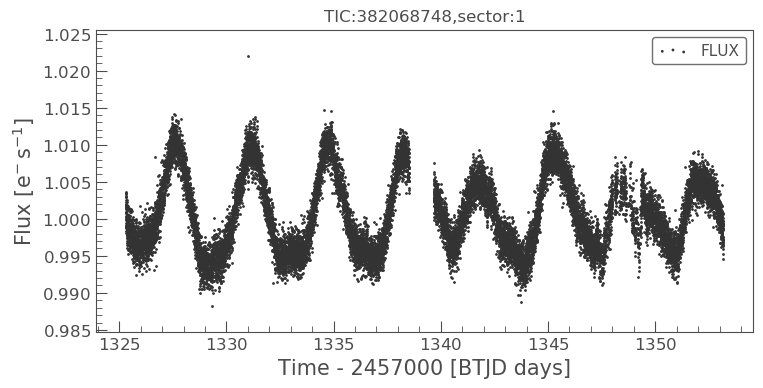

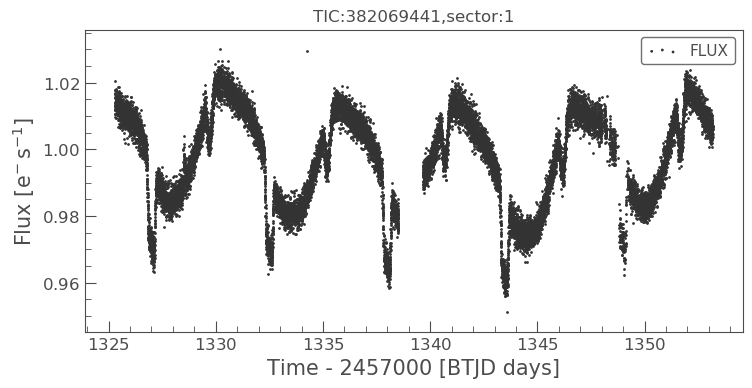

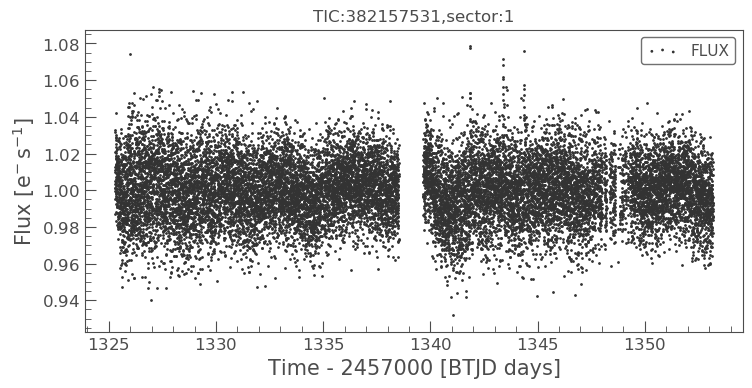

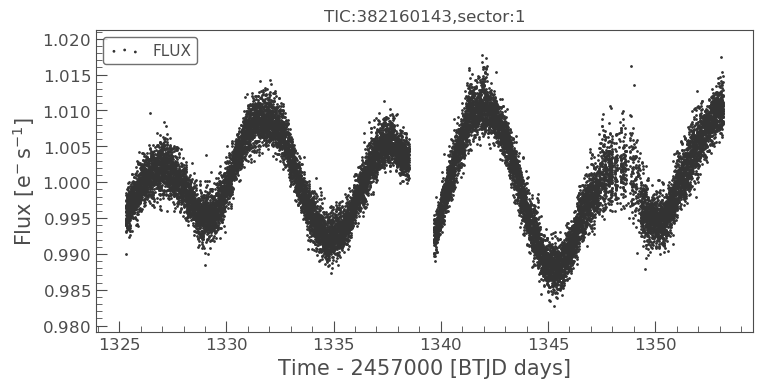

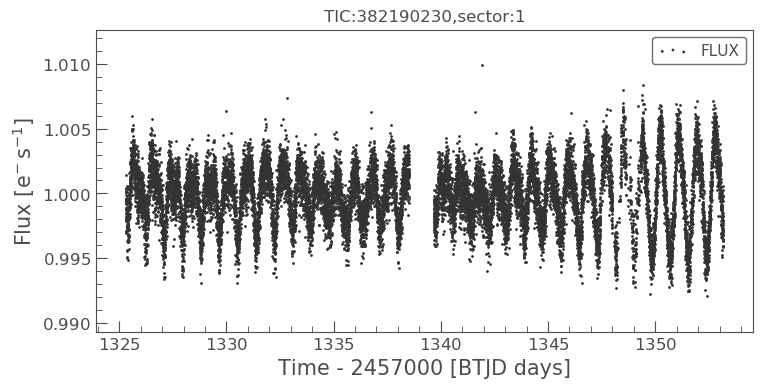

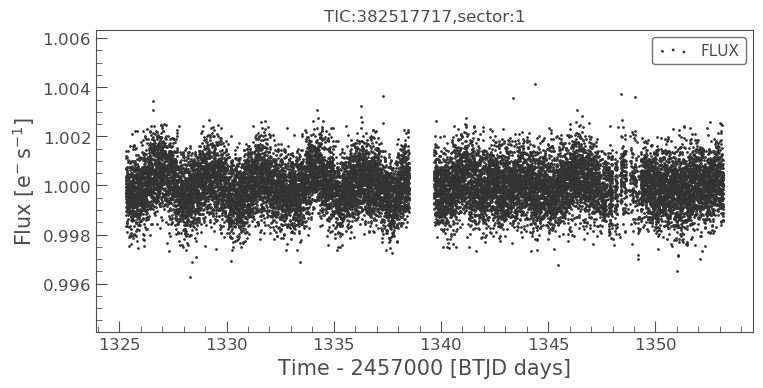

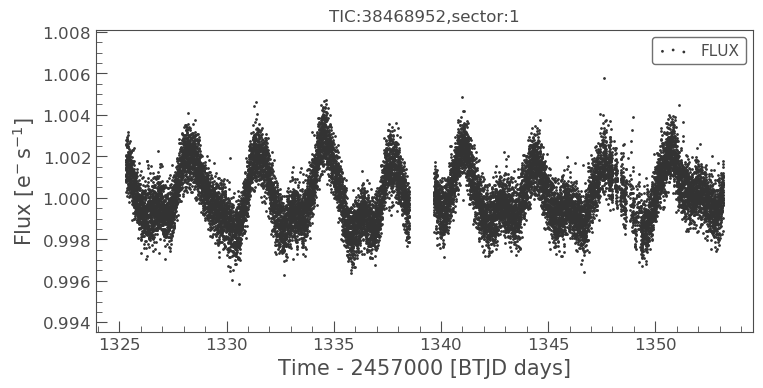

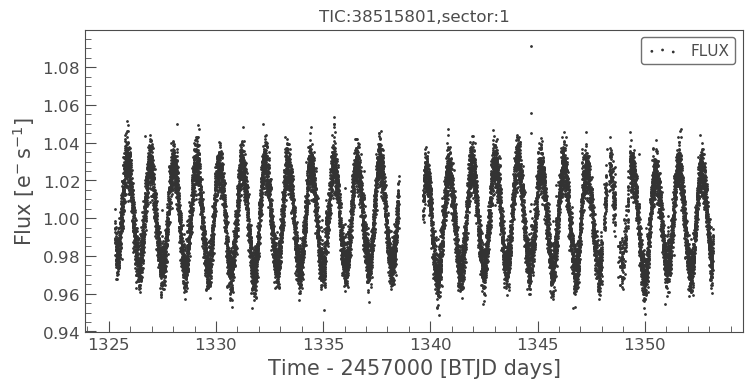

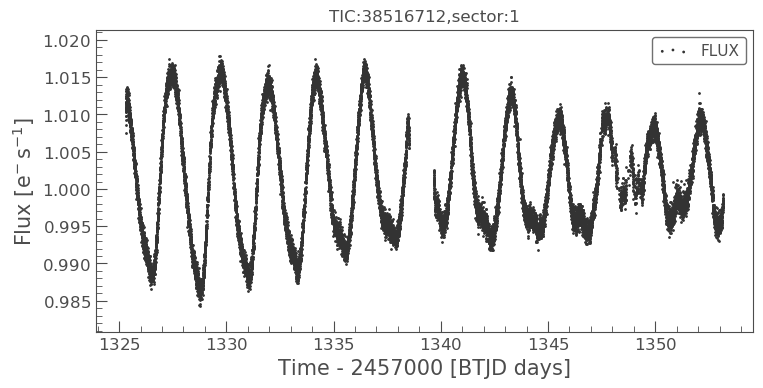

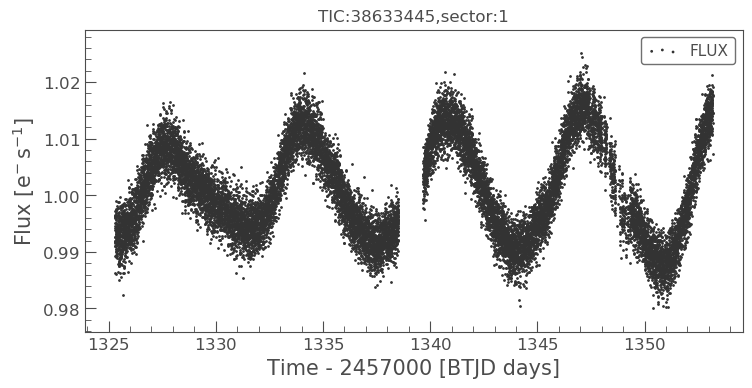

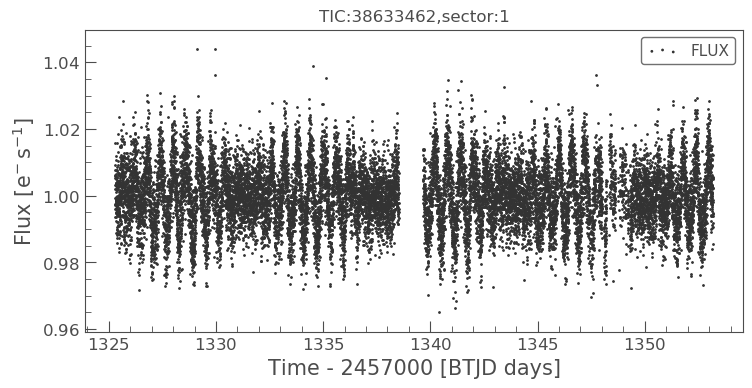

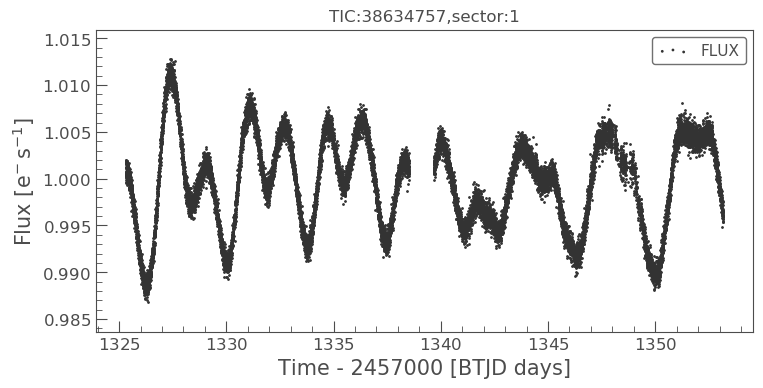

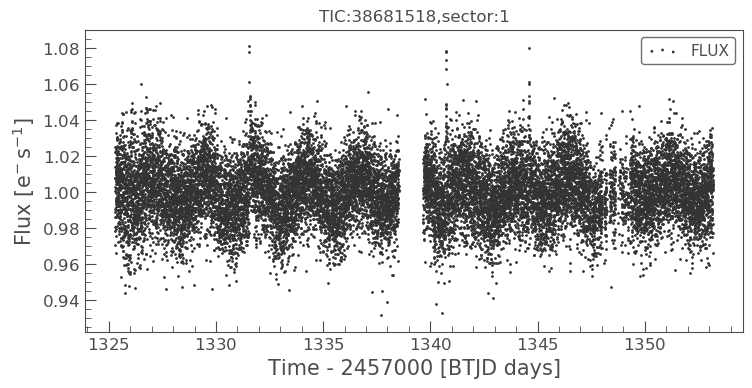

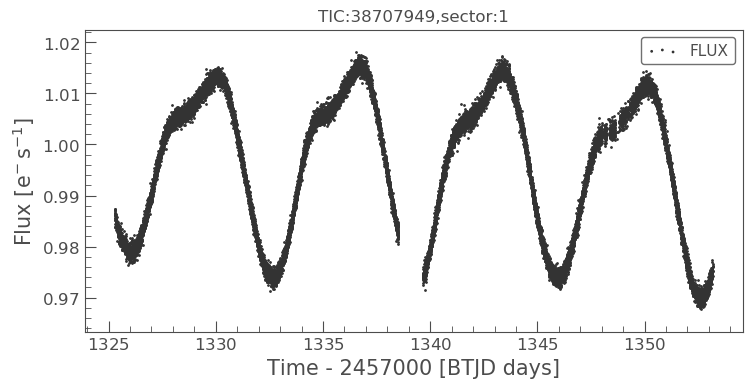

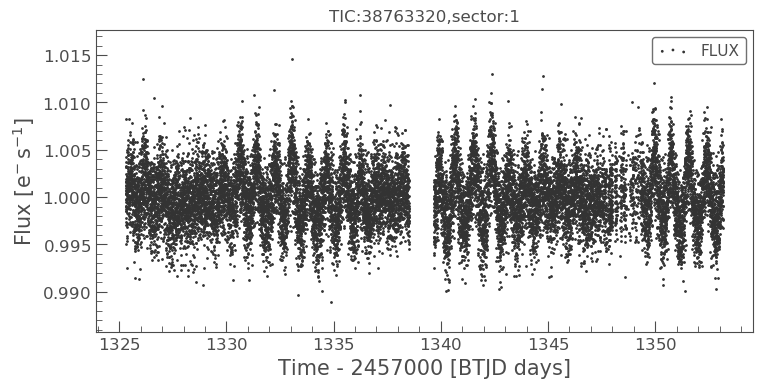

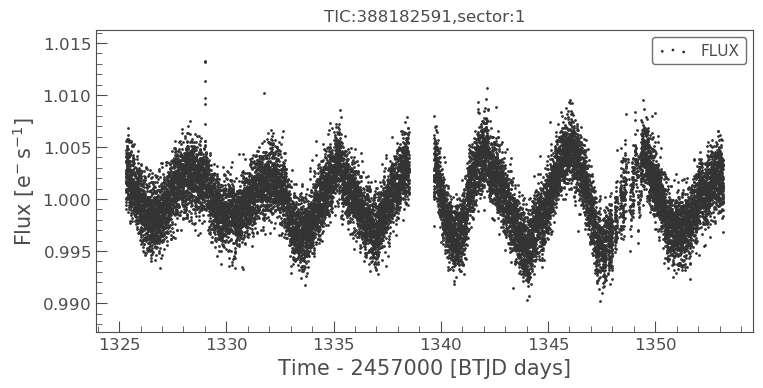

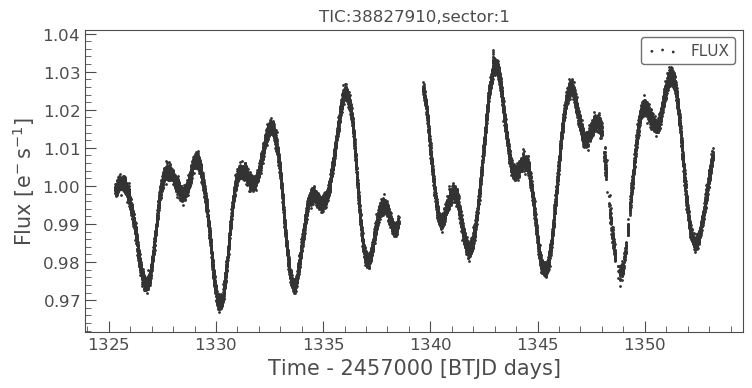

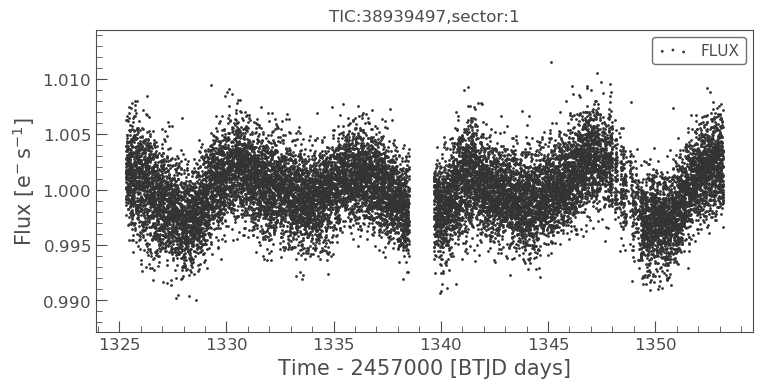

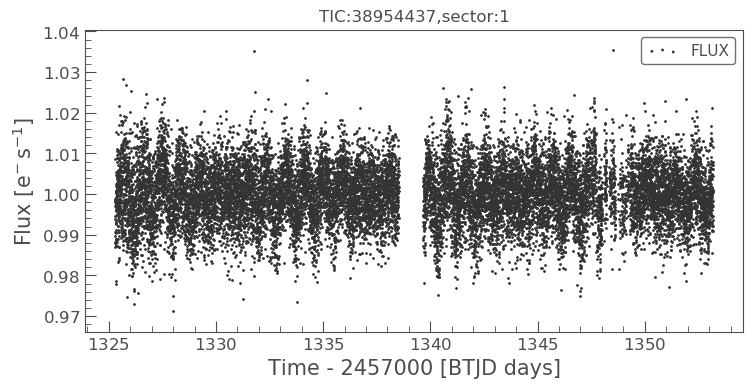

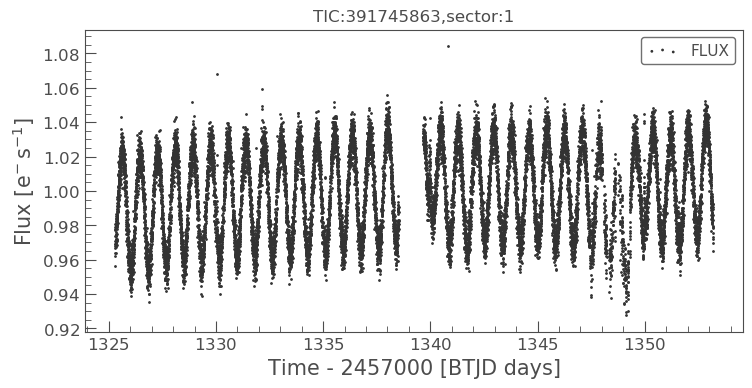

In [103]:
## used this to help find additional EBs b/c changed many of those to class 1 instead


# keys = list(consistent10.keys()) #to return dict keys as a subscriptable list
# #dictionary.keys() returns a set NOT a list ^^see above line
# for tic in keys[220:240]:
#     print(tic)
#     plot_1sector(tic)


## match predicted classes to dataset

In [56]:
#match predicitons to their tics to get stats
# for RF-2 only b/c most accurate

unseen_data['RF2predicted_class'] = predictions2 # 1+ sectors
unseen10up_data['RF2predicted_class'] = predictions10up2 # 10+ sectors


# unseen_data

In [57]:
# exploring properties to determine best bin sizes & find non-nan placeholder values (ie -9999)

for feature in unseen_data.columns: # unseen10up_data
    binrange = find_range(unseen_data[feature])
    print('For {} the range is: {}'.format(feature,binrange),'max:',np.max(unseen_data[feature]),'min:',np.min(unseen_data[feature]))

For ID the range is: 445309665.0 max: 469981586.0 min: 24671921.0
For rvar the range is: 215.70162588357925 max: 215.70187377929688 min: 0.0002478957176208496
For ls1 the range is: 48.91292351460538 max: 49.41296806902072 min: 0.5000445544153426
For ls2 the range is: 48.86429880985886 max: 49.364670339434866 min: 0.500371529576006
For ls3 the range is: 49.4502562388967 max: 49.950548462506745 min: 0.5002922236100468
For lsamp1 the range is: 1.0085163172153746 max: 1.0085555724164308 min: 3.9255201056113574e-05
For lsamp2 the range is: 0.8896001293178345 max: 0.88963669537557 min: 3.6566057735457144e-05
For lsamp3 the range is: 0.8671968546532941 max: 0.8672288029098018 min: 3.1948256507668594e-05
For acf1 the range is: 149.77650871 max: 149.77650871 min: 0.0
For acf2 the range is: 176.45153005 max: 176.45153005 min: 0.0
For acf3 the range is: 176.44180782 max: 176.44180782 min: 0.0
For acfamp1 the range is: 9999.995903304509 max: 0.99590330450844 min: -9999.0
For acfamp2 the range is: 

In [58]:
#mask nan values from the data placeholders for no acf2, acf3 etc

# training sample also has -9999??? check!
# 1+ sectors
nan_data = unseen_data.replace(-9999.0,np.nan)
masked_data = nan_data[~np.isnan(nan_data)]
# 10+ sectors
nan_data10 = unseen10up_data.replace(-9999.0,np.nan)
masked_data10 = nan_data10[~np.isnan(nan_data10)]

print(len(masked_data), len(masked_data10))

22727 5325


In [59]:
# again, exploring properties to determine best bin sizes

for feature in masked_data.columns: #masked_data10
    binrange = find_range(masked_data[feature])
    print('For {} the range is: {}'.format(feature,binrange))


For ID the range is: 445309665.0
For rvar the range is: 215.70162588357925
For ls1 the range is: 48.91292351460538
For ls2 the range is: 48.86429880985886
For ls3 the range is: 49.4502562388967
For lsamp1 the range is: 1.0085163172153746
For lsamp2 the range is: 0.8896001293178345
For lsamp3 the range is: 0.8671968546532941
For acf1 the range is: 149.77650871
For acf2 the range is: 176.45153005
For acf3 the range is: 176.44180782
For acfamp1 the range is: 1.6941549530967648
For acfamp2 the range is: 1.7102812581628672
For acfamp3 the range is: 1.7615849773855448
For Teff the range is: 47185.0
For Bmag the range is: 17.768
For Vmag the range is: 17.1
For Tmag the range is: 15.506499999999999
For random the range is: 0.9999509960038002
For RF2predicted_class the range is: 2


In [60]:
#################################################################
### switch btwn 10+/1+ sectors dataset for plots below with here
#################################################################


# uses masked data - masks np.nan's; 10+ sectors
usage = '10+ sectors'
class1 = masked_data10[masked_data10['RF2predicted_class']==1]
class2 = masked_data10[masked_data10['RF2predicted_class']==2]
class3 = masked_data10[masked_data10['RF2predicted_class']==3]


# ##uses masked data - masks np.nan's; 1+ sectors
# usage = '1+ sectors'
# class1 = masked_data[masked_data['RF2predicted_class']==1]
# class2 = masked_data[masked_data['RF2predicted_class']==2]
# class3 = masked_data[masked_data['RF2predicted_class']==3]

 Plots made with 10+ sectors


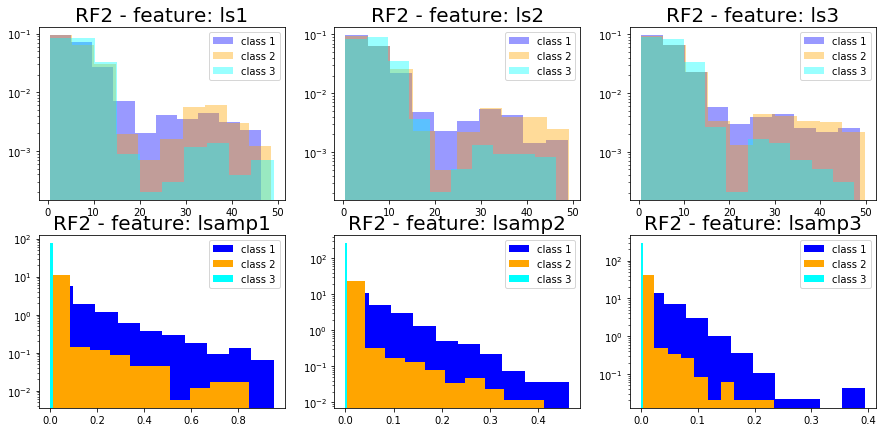

In [61]:
feature00 = 'ls1'
feature01 = 'ls2'
feature02 = 'ls3'
feature10 = 'lsamp1'
feature11 = 'lsamp2'
feature12 = 'lsamp3'
alpha = 0.4
print(' Plots made with {}'.format(usage))
# default is 10 bins

fig, ax = plt.subplots(2,3,figsize=(15,7))
ax[0,0].hist(class1[feature00],alpha=alpha, linestyle = '-',density = True, log=True,color='b',label='class 1')
ax[0,0].hist(class2[feature00],alpha=alpha, color='orange',density = True,log=True,label='class 2')
ax[0,0].hist(class3[feature00],alpha=alpha, color='cyan',density = True,log=True,label='class 3')
ax[0,0].set_title('RF2 - feature: {}'.format(feature00), fontsize=20)
ax[0,0].legend()
ax[0,1].hist(class1[feature01], alpha=alpha,color='b',density = True,log=True,label='class 1')
ax[0,1].hist(class2[feature01], alpha=alpha,color='orange',density = True,log=True,label='class 2')
ax[0,1].hist(class3[feature01], alpha = alpha, color='cyan',density = True,log=True,label='class 3')
ax[0,1].set_title('RF2 - feature: {}'.format(feature01), fontsize=20)
ax[0,1].legend()
ax[0,2].hist(class1[feature02], alpha=alpha,color='b',density = True,log=True,label='class 1')
ax[0,2].hist(class2[feature02], alpha=alpha,color='orange',density = True,log=True,label='class 2')
ax[0,2].hist(class3[feature02], alpha=alpha,color='cyan',density = True,log=True,label='class 3')
ax[0,2].set_title('RF2 - feature: {}'.format(feature02), fontsize=20)
ax[0,2].legend()

ax[1,0].hist(class1[feature10], color='b',density = True,log=True,label='class 1')
ax[1,0].hist(class2[feature10], color='orange',density = True,log=True,label='class 2')
ax[1,0].hist(class3[feature10], 1,color='cyan',density = True,log=True,label='class 3',zorder=2)
ax[1,0].set_title('RF2 - feature: {}'.format(feature10), fontsize=20)
ax[1,0].legend()
ax[1,1].hist(class1[feature11], color='b',density = True,log=True,label='class 1')
ax[1,1].hist(class2[feature11], color='orange',density = True,log=True,label='class 2')
ax[1,1].hist(class3[feature11], 1,color='cyan',density = True,log=True,label='class 3',zorder=2)
# ax[1,1].set_xlim(0,0.1) #to see class3
ax[1,1].set_title('RF2 - feature: {}'.format(feature11), fontsize=20)
ax[1,1].legend()
ax[1,2].hist(class1[feature12], color='b',density = True,log=True,label='class 1')
ax[1,2].hist(class2[feature12], color='orange',density = True,log=True,label='class 2')
ax[1,2].hist(class3[feature12], 1,color='cyan',density = True,log=True,label='class 3',zorder=2)
# ax[1,2].set_xlim(0,.1) #to see class3
ax[1,2].set_title('RF2 - feature: {}'.format(feature12), fontsize=20)
ax[1,2].legend()

 Plots made with 10+ sectors


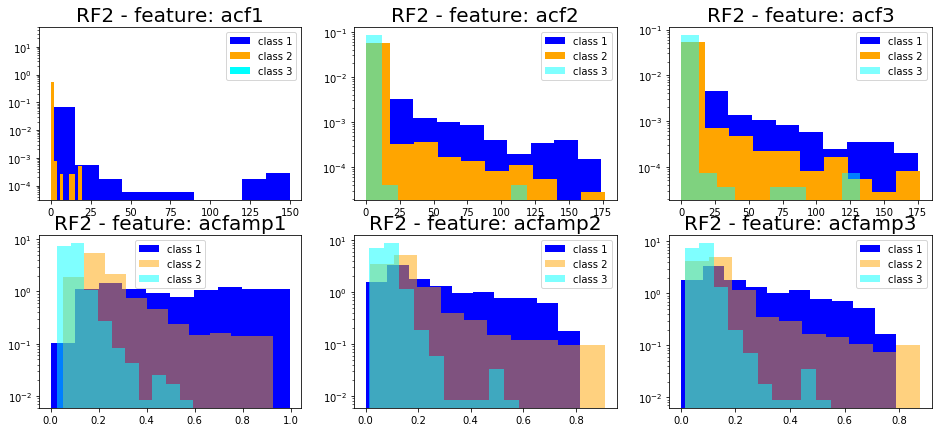

In [62]:
feature00 = 'acf1'
feature01 = 'acf2'
feature02 = 'acf3'
feature10 = 'acfamp1'
feature11 = 'acfamp2'
feature12 = 'acfamp3'
bins=10
alpha = 0.5
print(' Plots made with {}'.format(usage))



fig, ax = plt.subplots(2,3,figsize=(16,7))
ax[0,0].hist(class1[feature00],bins, density=True,log=True,color='b',label='class 1')
ax[0,0].hist(class2[feature00],bins,density=True,log=True, color='orange',label='class 2')
ax[0,0].hist(class3[feature00],bins,density=True,log=True, color='cyan',label='class 3',zorder=2)
ax[0,0].set_title('RF2 - feature: {}'.format(feature00), fontsize=20)
# ax[0,0].set_xlim(-1,10) #to see class3
ax[0,0].legend()
ax[0,1].hist(class1[feature01],bins,density=True,  log=True,color='b',label='class 1')
ax[0,1].hist(class2[feature01],bins, density=True,log=True,color='orange',label='class 2')
ax[0,1].hist(class3[feature01],bins, density=True,log=True,alpha=alpha,color='cyan',label='class 3')
ax[0,1].set_title('RF2 - feature: {}'.format(feature01), fontsize=20)
ax[0,1].legend()
ax[0,2].hist(class1[feature02], bins,density=True,log=True,color='b',label='class 1')
ax[0,2].hist(class2[feature02],bins, density=True,log=True,color='orange',label='class 2')
ax[0,2].hist(class3[feature02], bins,density=True,log=True,alpha=alpha,color='cyan',label='class 3')
ax[0,2].set_title('RF2 - feature: {}'.format(feature02), fontsize=20)
ax[0,2].legend()

ax[1,0].hist(class1[feature10],bins, density=True,log=True,color='b',label='class 1')
ax[1,0].hist(class2[feature10],bins,density=True, log=True,alpha=alpha,color='orange',label='class 2')
ax[1,0].hist(class3[feature10],bins,density=True, log=True,alpha=alpha,color='cyan',label='class 3')
ax[1,0].set_title('RF2 - feature: {}'.format(feature10), fontsize=20)
ax[1,0].legend()
ax[1,1].hist(class1[feature11], density=True,log=True,color='b',label='class 1')
ax[1,1].hist(class2[feature11], density=True,log=True,alpha=alpha,color='orange',label='class 2')
ax[1,1].hist(class3[feature11], density=True,log=True,alpha=alpha,color='cyan',label='class 3')
ax[1,1].set_title('RF2 - feature: {}'.format(feature11), fontsize=20)
ax[1,1].legend()
ax[1,2].hist(class1[feature12], density=True,log=True,color='b',label='class 1')
ax[1,2].hist(class2[feature12], density=True,log=True,alpha=alpha,color='orange',label='class 2')
ax[1,2].hist(class3[feature12], density=True,log=True,alpha=alpha,color='cyan',label='class 3')
ax[1,2].set_title('RF2 - feature: {}'.format(feature12), fontsize=20)
ax[1,2].legend();

In [63]:
print('how is there a negative amplitude??')
print(' Plots made with {}'.format(usage))


np.min(class1[feature10]),feature10

how is there a negative amplitude??
 Plots made with 10+ sectors


(0.0011593944192684507, 'acfamp1')

 Plots made with 10+ sectors


(-1, 10)

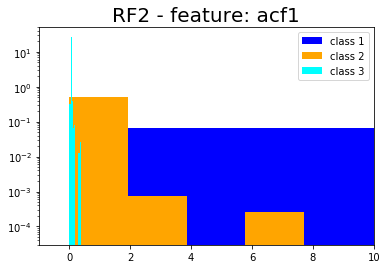

In [64]:
#test one figure to get bin sizes

print(' Plots made with {}'.format(usage))
bins=10
plt.hist(class1[feature00],bins, density=True,log=True,color='b',label='class 1')
plt.hist(class2[feature00],bins, density=True,log=True,color='orange',label='class 2')
plt.hist(class3[feature00],bins, density=True,log=True,color='cyan',label='class 3',zorder=2)
plt.title('RF2 - feature: {}'.format(feature00), fontsize=20)
plt.legend();

# plt.ylim(0,.001)
plt.xlim(-1,10)

 Plots made with 10+ sectors


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


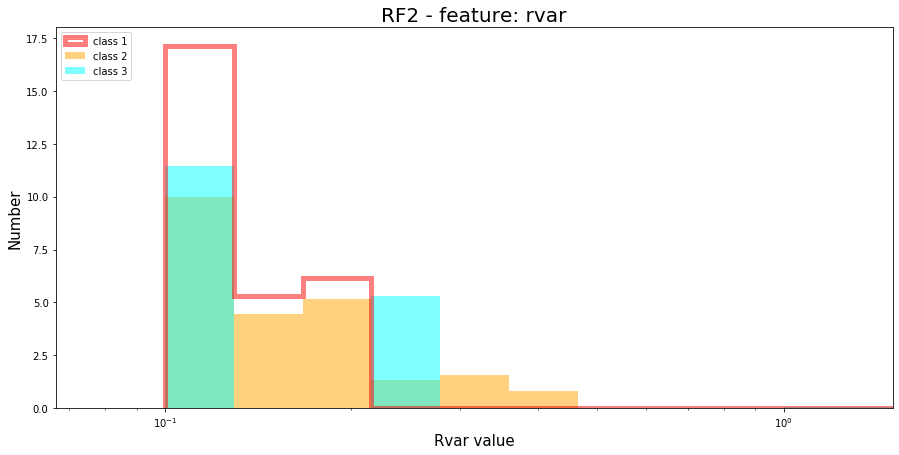

In [65]:
feature = 'rvar'
bin1 = np.logspace(np.log10(0.1),np.log10(1.0), 10) 
bins = np.append(bin1, [10,100,200,350])
alpha = 0.5
print(' Plots made with {}'.format(usage))


plt.figure(figsize=(15,7))
plt.hist(class1[feature],bins, density=True,color='r',label='class 1',zorder=2, alpha= alpha,histtype='step',linewidth=5)#,linestyle=':'
plt.hist(class2[feature],bins, density=True,color='orange',label='class 2',zorder=0, alpha= alpha)
plt.hist(class3[feature],bins, density=True,color='cyan',label='class 3',zorder=1, alpha= alpha)
plt.title('RF2 - feature: {}'.format(feature), fontsize=20)
plt.xlabel('Rvar value',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.xscale("log")
# plt.yscale('log')
plt.xlim(0,1.5)
plt.legend();
# plt.ylim(0,1)

In [66]:
class1

ID      rvar        ls1        ls2        ls3    lsamp1  \
6     25132314.0  0.003282   1.049705   1.045446   1.053933  0.640197   
8     25153007.0  0.002014   2.333734   2.312152   2.355722  0.087061   
9     25155664.0  0.008279   2.391303   1.195626   0.797091  0.648140   
10    25196356.0  0.001644   2.148664   2.131525   2.115720  0.032851   
14    29781099.0  0.001699   1.437684   2.876590   1.429627  0.305427   
...          ...       ...        ...        ...        ...       ...   
5731  55755266.0  0.006850   8.221357  11.170876  10.699909  0.004613   
5734  55758485.0  0.005108   2.389154   2.332117   2.364767  0.246857   
5735  55758788.0  0.009470   9.352536   5.546238   9.957342  0.074798   
5753  55850719.0  0.002138   2.757688   2.867932   2.728045  0.008048   
5755  55852584.0  0.038597  28.645457  35.765789  23.912108  0.211855   

        lsamp2    lsamp3        acf1        acf2       acf3   acfamp1  \
6     0.065802  0.059022    1.037501    2.088891   3.148614  0.705951   
8     0.007636  0.006161    0.070833    2.354169   2.351391  0.140090   
9     0.174882  0.073263    2.394446   14.355567   4.784726  0.748221   
10    0.009295  0.004259    0.069445    2.133335   2.130557  0.115440   
14    0.025349  0.025175    0.069445    2.873613   2.877780  0.416615   
...        ...       ...         ...         ...        ...       ...   
5731  0.004484  0.003442    0.069445    0.254167   0.481945  0.122750   
5734  0.134218  0.127566    0.069445    2.365280   4.733337  0.877270   
5735  0.024755  0.017181    0.069445    9.059729   9.062507  0.434625   
5753  0.006958  0.006496    0.069445    2.597224   2.593058  0.215263   
5755  0.175195  0.163588  143.679282  143.676504  24.168075  0.268947   

       acfamp2   acfamp3     Teff    Bmag    Vmag     Tmag    random  \
6     0.597963  0.560923  6867.00   8.680   8.380   8.0289  0.012781   
8     0.078018  0.078011  7109.00   9.568   9.219   8.8967  0.487372   
9     0.728230  0.682559  7178.00   7.289   6.990   6.6683  0.941807   
10    0.043508  0.043505  6634.00   9.376   8.903   8.4861  0.850795   
14    0.298443  0.298430  8214.00   8.227   8.050   7.9169  0.893904   
...        ...       ...      ...     ...     ...      ...       ...   
5731  0.105885  0.090037  5153.47  13.777  11.981  11.2353  0.546644   
5734  0.605172  0.505395  6350.00   9.754   8.940   8.4796  0.792275   
5735  0.181335  0.181317  5439.51  12.894  12.112  11.4605  0.570986   
5753  0.048358  0.048352  6378.60   9.740   9.312   8.9374  0.604284   
5755  0.268947  0.113656  3327.00   9.617   8.149   5.6103  0.750325   

      RF2predicted_class  
6                      1  
8                      1  
9                      1  
10                     1  
14                     1  
...                  ...  
5731                   1  
5734                   1  
5735                   1  
5753                   1  
5755                   1  

[1169 rows x 20 columns]

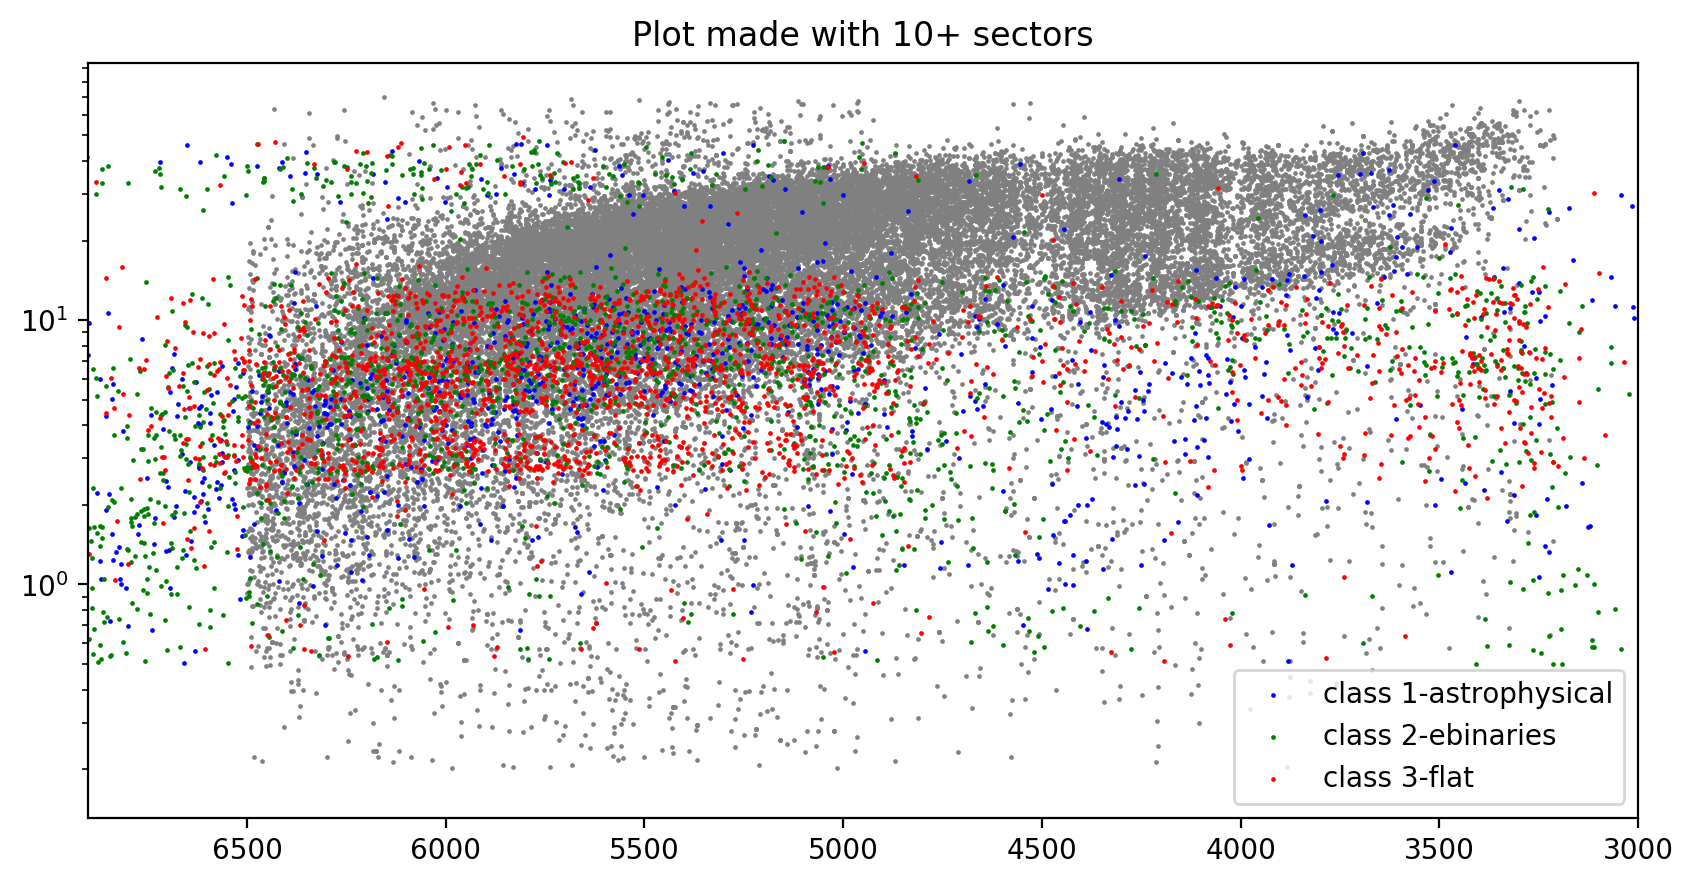

In [67]:
# plot just class 1 over mq dataset

plt.figure(figsize=(10,5),dpi=200)

plt.scatter(class1['Teff'],class1['ls1'],s=.5,color='b',label='class 1-astrophysical')
plt.scatter(class2['Teff'],class2['ls1'],s=.5,color='g',label='class 2-ebinaries')
plt.scatter(class3['Teff'],class3['ls1'],s=.5,color='r',label='class 3-flat')


plt.scatter(mqdata['TEMP'],mqdata['ROTATION_PERIOD'],s=.5,zorder=0,color = 'grey', rasterized=True)
plt.yscale('log')
# plt.ylim(0,40)
plt.legend()
plt.title('Plot made with {}'.format(usage))
plt.xlim(6900,3000);

# TESTS

In [68]:
# np.max(unseen_data['rvar']), np.log10(1), np.logspace(np.log10(0.1),np.log10(1.0), 50)
np.sort(unseen_data['rvar'])[-50:]

array([  0.96371771,   0.96556681,   0.99420029,   0.9997368 ,
         1.02862481,   1.03021042,   1.0822274 ,   1.08900861,
         1.09335079,   1.13286839,   1.13469831,   1.14374199,
         1.1483157 ,   1.1724641 ,   1.22039713,   1.24030545,
         1.33150384,   1.53814178,   1.57041623,   1.58025632,
         1.58146885,   1.6104615 ,   1.64815073,   1.68740149,
         1.76476148,   1.86333513,   2.21428541,   2.26380346,
         2.54039379,   2.75553228,   2.92086599,   3.16062163,
         3.35328293,   3.71194657,   3.92075168,   4.00899346,
         4.17714608,   6.01276398,   7.16618156,   8.62885308,
        10.63147068,  11.04879866,  11.48307152,  14.87506332,
        16.37819827,  20.66269436,  32.60285759,  53.68270836,
        64.46950788, 215.70187378])

In [69]:
testbin1 = np.logspace(np.log10(0.1),np.log10(1.0), 50) #,np.log10(10.0)
testbin2 = np.append(testbin1, [10,100,200,350])
testbin1, testbin2

(array([0.1       , 0.10481131, 0.10985411, 0.11513954, 0.12067926,
        0.12648552, 0.13257114, 0.13894955, 0.14563485, 0.1526418 ,
        0.15998587, 0.16768329, 0.17575106, 0.184207  , 0.19306977,
        0.20235896, 0.21209509, 0.22229965, 0.23299518, 0.24420531,
        0.25595479, 0.26826958, 0.28117687, 0.29470517, 0.30888436,
        0.32374575, 0.33932218, 0.35564803, 0.37275937, 0.39069399,
        0.40949151, 0.42919343, 0.44984327, 0.47148664, 0.49417134,
        0.51794747, 0.54286754, 0.5689866 , 0.59636233, 0.62505519,
        0.65512856, 0.68664885, 0.71968567, 0.75431201, 0.79060432,
        0.82864277, 0.86851137, 0.91029818, 0.95409548, 1.        ]),
 array([1.00000000e-01, 1.04811313e-01, 1.09854114e-01, 1.15139540e-01,
        1.20679264e-01, 1.26485522e-01, 1.32571137e-01, 1.38949549e-01,
        1.45634848e-01, 1.52641797e-01, 1.59985872e-01, 1.67683294e-01,
        1.75751062e-01, 1.84206997e-01, 1.93069773e-01, 2.02358965e-01,
        2.12095089e-01, 2.2229

In [70]:
#consistent sector tics

#predictions that are only ebs
ebs_fromrf =[]
for row in predictions2:
#     print(row)
    classes = row['class']
    if classes == 3:
        tic = row['tic']
        ebs_fromrf.append(tic)
        
# ebs_fromrf = [predicts['tic'] if predicts['class']==3]


IndexError: invalid index to scalar variable.

In [ ]:
#find how many matched

consist_ebs = consistent10.keys()


notin_rf, notin_consist = returnNotMatches(consist_ebs,ebs_fromrf)
print(len(notin_rf),len(notin_consist))

In [ ]:
len(ebs_fromrf),len(consist_ebs)

In [ ]:
np.min(bigstats['TOTsecs']),np.max(bigstats['TOTsecs'])